In [1]:
import numpy as np
import pandas as pd
from pyirr import intraclass_correlation
pd.options.display.max_rows = 200
import matplotlib.pyplot as plt
import seaborn as sns
import copy
sns.set_style('whitegrid')

In [2]:
# load data
df = pd.read_csv('/Users/morton/Dicom Files/RADSARC_R/XNAT/extractions/extractions__20220910_1006_allRegions/radiomicFeatures/radiomicFeatures.csv')
df.drop(list(df.filter(regex = 'source')), axis = 1, inplace = True)
df.drop(list(df.filter(regex = 'diagnostic')), axis = 1, inplace = True)

dfRep = pd.read_csv('/Users/morton/Dicom Files/RADSARC_R/XNAT/extractions/extractions__20220914_1117_repro/radiomicFeatures/radiomicFeatures.csv')
dfRep.drop(list(dfRep.filter(regex = 'source')), axis = 1, inplace = True)
dfRep.drop(list(dfRep.filter(regex = 'diagnostic')), axis = 1, inplace = True)

subjectIDs = df.merge(dfRep, on='StudyPatientName').StudyPatientName

# select rows and make sure they are both sorted on SubjectID
df = df.loc[df['StudyPatientName'].isin(subjectIDs)]
df.sort_values('StudyPatientName', axis=0, inplace=True)

dfRep = dfRep.loc[dfRep['StudyPatientName'].isin(subjectIDs)]
dfRep.sort_values('StudyPatientName', axis=0, inplace=True)

# remove texture features
# groups = 'shape|firstorder|sarcomaFeature|StudyPatientName'
# df = df.filter(regex = groups)
# dfRep = dfRep.filter(regex = groups)

# remove high/mid/low_enhancing features
df.drop(list(df.filter(regex = 'low_enhancing_original')), axis = 1, inplace = True)
dfRep.drop(list(dfRep.filter(regex = 'low_enhancing_original')), axis = 1, inplace = True)
df.drop(list(df.filter(regex = 'mid_enhancing_original')), axis = 1, inplace = True)
dfRep.drop(list(dfRep.filter(regex = 'mid_enhancing_original')), axis = 1, inplace = True)
df.drop(list(df.filter(regex = 'high_enhancing_original')), axis = 1, inplace = True)
dfRep.drop(list(dfRep.filter(regex = 'high_enhancing_original')), axis = 1, inplace = True)

# remove these features
df.drop(list(df.filter(regex = 'calcificationDeleted')), axis = 1, inplace = True)
dfRep.drop(list(dfRep.filter(regex = 'calcificationDeleted')), axis = 1, inplace = True)

df.reset_index(inplace=True)
dfRep.reset_index(inplace=True)

df = df.rename(columns=lambda x:x.replace('lesion_original_',''))
dfRep = dfRep.rename(columns=lambda x:x.replace('lesion_original_',''))

In [3]:
# take logs of some features
logFeatures = ['shape_MeshVolume', 'shape_SurfaceArea', 'shape_SurfaceVolumeRatio', 'shape_VoxelVolume', 
               'firstorder_Energy', 'firstorder_TotalEnergy', 'firstorder_Variance']
for feat in df.columns:
    if any([y in feat for y in logFeatures]):
        df.loc[:,feat + '_log10'] = np.log10(df[feat])
        dfRep.loc[:,feat + '_log10'] = np.log10(dfRep[feat])

In [4]:
iccValues = []
featNames = []
for col in df.columns:
    if col == 'StudyPatientName' or col=='index':
        continue
    data = np.stack((df[col], dfRep[col]), axis=1)
    featNames.append(col)
    iccValues.append(intraclass_correlation(data, "twoway", "agreement").value)
iccDf = pd.DataFrame({'Feature':featNames, 'ICC':iccValues})

# display for feature with ICC under some threshold

iccThreshold = 0.9

iccDfgroup = iccDf.loc[iccDf['Feature'].str.contains('VolumeFraction'),:]

print('Group = ' + str('VolumeFraction').ljust(12) + ': # features with ICC > ' + str(iccThreshold) + ' = ' + str(np.sum(iccDfgroup.ICC>=iccThreshold)) + '/' + str(iccDfgroup.shape[0]))

iccDfgroup = iccDfgroup.sort_values('ICC', ascending=False)
display(iccDfgroup.style.hide_index())
print('\n\n\n')


for group in ['shape', 'firstorder']:
    iccDfgroup = iccDf[iccDf['Feature'].str.contains(group)]
    
    print('Group = ' + str(group).ljust(12) + ': # features with ICC > ' + str(iccThreshold) + ' = ' + str(np.sum(iccDfgroup.ICC>=iccThreshold)) + '/' + str(iccDfgroup.shape[0]))

    iccDfgroup = iccDfgroup.loc[iccDfgroup.ICC < iccThreshold, :]
    iccDfgroup.sort_values('ICC', ascending=False, inplace=True)
    display(iccDfgroup.style.hide_index())
    print('\n\n\n')
    
# do the same for all features except any in the groups listed (i.e. texture features)
iccDfgroup = copy.deepcopy(iccDf)
for group in ['VolumeFraction', 'shape', 'firstorder']:
    iccDfgroup.drop(list(iccDfgroup.filter(regex = group)), axis = 1, inplace = True)

print('Group = ' + 'texture'.ljust(12) + ': # features with ICC > ' + str(iccThreshold) + ' = ' + str(np.sum(iccDfgroup.ICC>=iccThreshold)) + '/' + str(iccDfgroup.shape[0]))

iccDfgroup = iccDfgroup.loc[iccDfgroup.ICC < iccThreshold, :]
iccDfgroup.sort_values('ICC', ascending=False, inplace=True)
display(iccDfgroup.style.hide_index())


Group = VolumeFraction: # features with ICC > 0.9 = 4/4


Feature,ICC
lesion_sarcomaFeature_high enhancingVolumeFraction,0.999634
lesion_sarcomaFeature_calcificationVolumeFraction,0.999527
lesion_sarcomaFeature_low enhancingVolumeFraction,0.999387
lesion_sarcomaFeature_mid enhancingVolumeFraction,0.998163






Group = shape       : # features with ICC > 0.9 = 17/18


Feature,ICC
shape_Sphericity,0.744187






Group = firstorder  : # features with ICC > 0.9 = 19/21


Feature,ICC
firstorder_Range,0.867131
firstorder_Minimum,0.745184






Group = texture     : # features with ICC > 0.9 = 106/132


Feature,ICC
glcm_Idmn,0.895773
glcm_Idn,0.891949
firstorder_Range,0.867131
ngtdm_Contrast,0.844910
firstorder_Minimum,0.745184
shape_Sphericity,0.744187
gldm_SmallDependenceLowGrayLevelEmphasis,0.718872
glszm_SmallAreaLowGrayLevelEmphasis,0.660293
gldm_LowGrayLevelEmphasis,0.648195
glrlm_ShortRunLowGrayLevelEmphasis,0.641043


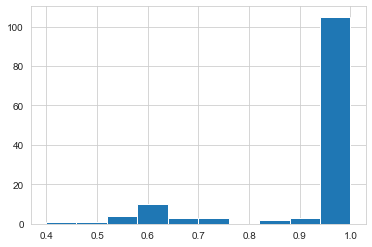

In [5]:
plt.hist(iccDf.ICC)
plt.show()

In [6]:
feat = 'firstorder_Minimum'
pd.concat([df[['StudyPatientName', feat]], dfRep[['StudyPatientName', feat]]], axis=1)

,StudyPatientName,firstorder_Minimum,StudyPatientName,firstorder_Minimum
0,RMH_RSRC009,-440.843817,RMH_RSRC009,-203.444360
1,RMH_RSRC018,-46.660642,RMH_RSRC018,-29.591608
2,RMH_RSRC021,-69.001953,RMH_RSRC021,-25.675709
3,RMH_RSRC034,-6.287474,RMH_RSRC034,-38.187299
4,RMH_RSRC036,-418.339567,RMH_RSRC036,-320.959602
5,RMH_RSRC041,5.416220,RMH_RSRC041,-36.524351
6,RMH_RSRC046,-112.201799,RMH_RSRC046,-107.244158
7,RMH_RSRC048,-83.310770,RMH_RSRC048,-85.442586
8,RMH_RSRC053,-143.681416,RMH_RSRC053,-143.681416
9,RMH_RSRC056,-56.633333,RMH_RSRC056,-117.750000


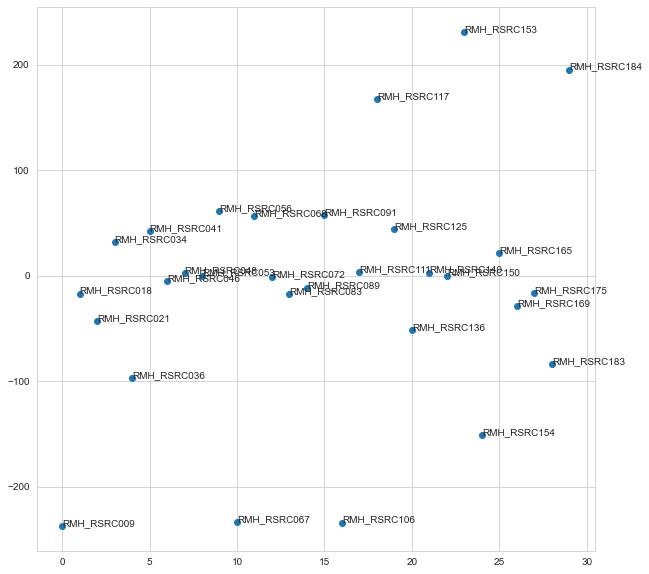

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
y = df[feat] - dfRep[feat]
ax.scatter(range(df.shape[0]), y)
for i in range(df.shape[0]):
    ax.annotate(df.loc[i,'StudyPatientName'], (i, y[i]))
plt.show()
